<a href="https://colab.research.google.com/github/Shiv1143/Finetuning_LLM_LoRA/blob/main/Finetune_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

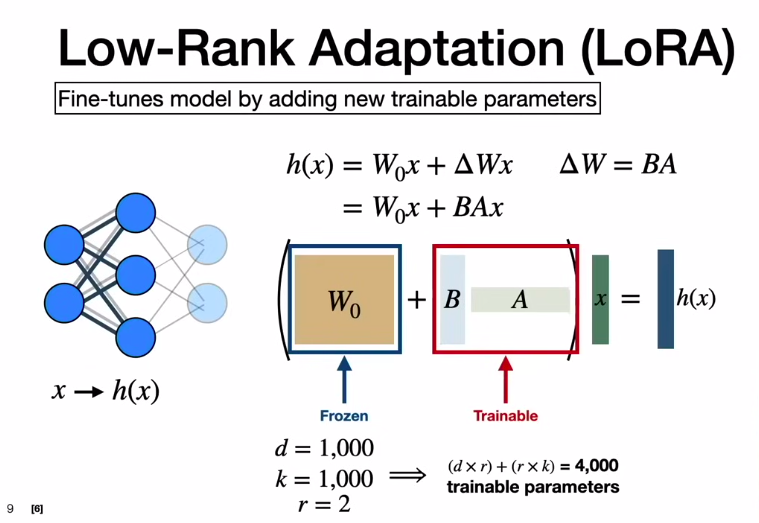

## Installing Dependencies

In [1]:
pip install transformers[torch]

In [2]:
pip install datasets

In [10]:
pip install accelerate -U

In [11]:
import datasets

In [12]:
from datasets import load_dataset, DatasetDict, Dataset

In [13]:
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)

In [14]:
pip install peft

In [15]:
from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import torch
import numpy as np

In [16]:
model_checkpoint = 'distilbert-base-uncased'

#define label maps
id2label = {0: "Negative", 1: "Positive"}
label2id = {"Negative": 0, "Positive": 1}

In [17]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [19]:
#load datset
dataset = load_dataset("/content/dataset_finetune")
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
})

In [46]:
dataset = load_dataset("shawhin/imdb-truncated")

In [50]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
})

In [53]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

def tokenize_function(examples):
  text = examples["text"]

  tokenizer.truncation_side = "left"
  tokenized_inputs = tokenizer(
      text,
      return_tensors='np',
      truncation=True,
      max_length=512
  )
  return tokenized_inputs

if tokenizer.pad_token is None:
  tokenizer.add_special_token({'pad_token': '[PAD]'})
  model.resize_token_embeddings(len(tokenizer))



In [69]:
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
})

In [55]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='left', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [56]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [57]:
pip install evaluate

In [58]:
import evaluate

In [59]:
accuracy = evaluate.load('accuracy')

In [60]:
def compute_metrics(p):
  predictions, labels = p
  predictions = np.argmax(predictions, axis=1)

  return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}

## Untraiined Model Performance

In [61]:
text_list = ["It was good.", "Not a fan, don't recommend",
             "Better than the first one.", "This is not worth watching even once.",
             "This one is a pass."]

In [62]:
for text in text_list:
  inputs = tokenizer.encode(text, return_tensors='pt')
  logits = model(inputs).logits
  predictions = torch.argmax(logits)

  print( text + " - " + id2label[predictions.tolist()])

It was good. - Negative
Not a fan, don't recommend - Negative
Better than the first one. - Negative
This is not worth watching even once. - Negative
This one is a pass. - Negative


## Training the model

In [63]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                         r=4,
                         lora_alpha=32,
                         lora_dropout=0.01,
                         target_modules = ['q_lin'])

In [64]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 628,994 || all params: 67,584,004 || trainable%: 0.9306847223789819


In [65]:
#hyperparameters
lr = 1e-3
batch_size = 4
num_epochs = 10

In [66]:
#training arrguments
training_args = TrainingArguments(
    output_dir=model_checkpoint + "-lora-text-classification",
    learning_rate = lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    save_strategy="epoch",
    load_best_model_at_end=True
)

In [70]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.366582,{'accuracy': 0.884}
2,0.413700,0.453993,{'accuracy': 0.891}
3,0.413700,0.518881,{'accuracy': 0.896}
4,0.187000,0.679882,{'accuracy': 0.889}
5,0.187000,0.795099,{'accuracy': 0.876}
6,0.060800,0.884876,{'accuracy': 0.878}
7,0.060800,0.996908,{'accuracy': 0.876}
8,0.012000,1.003080,{'accuracy': 0.886}
9,0.012000,1.021359,{'accuracy': 0.882}
10,0.006300,1.012241,{'accuracy': 0.882}


Trainer is attempting to log a value of "{'accuracy': 0.884}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.891}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.896}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.889}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.876}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This i

TrainOutput(global_step=2500, training_loss=0.13593782482147218, metrics={'train_runtime': 510.6533, 'train_samples_per_second': 19.583, 'train_steps_per_second': 4.896, 'total_flos': 1113026652407424.0, 'train_loss': 0.13593782482147218, 'epoch': 10.0})

## Testing the sample text

In [71]:
model.to('cpu')

print("trained_model predictions:")
print("--------------------------")

for text in text_list:
  inputs = tokenizer.encode(text, return_tensors='pt').to('cpu')

  logits = model(inputs).logits
  predictions = torch.max(logits,1).indices

  print(text + "-" + id2label[predictions.tolist()[0]])

trained_model predictions:
--------------------------
It was good.-Positive
Not a fan, don't recommend-Negative
Better than the first one.-Positive
This is not worth watching even once.-Negative
This one is a pass.-Negative
